In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
sns.set_style("darkgrid")

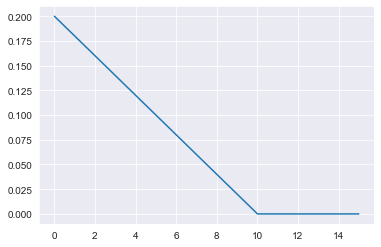

In [105]:
x_arr = np.arange(0, 15, step=0.001)
plt.plot(x_arr, ss.triang.pdf(x_arr, 0, loc=0, scale=10)) #scale = b-a, loc=a, c=procent

In [49]:
class PoissonProcess():
    
    def __init__(self, t, T, lbd):
        
        self.t = t
        self.T = T
        self.N = int(T/t)
        self.lbd = lbd
        poisson_rvs = ss.poisson.rvs(lbd*self.t, size=self.N)
        self.increments = poisson_rvs
        self.trajectory = np.concatenate([np.zeros(1), np.cumsum(poisson_rvs)])
        
    def plot(self):
        
        plt.plot(np.arange(0, self.T+self.t, step=self.t), self.trajectory)
        plt.ylabel("$N_t$")
        plt.xlabel("t")
        plt.title(f'Poisson process with $\delta t = {self.t}$, $T = {self.T}$ and $\lambda = {self.lbd}$')
        plt.show()
        
    def EN(self):
        return np.mean(self.trajectory)
    
    def VarN(self):
        return np.var(self.trajectory)
    
    def ENt(self):
        return [np.mean(self.trajectory[:i]) for i in np.arange(1, self.N + 1)]
    
    def VarNt(self):
        return [np.var(self.trajectory[:i]) for i in np.arange(1, self.N + 1)]
    

def generate_pareto(lbd, alpha, num):
    uni_rand = ss.uniform.rvs(size=num)
    return lbd/((1-uni_rand)**(1/alpha)) - lbd
        
class CompoundPoisson():
    
    def __init__(self, poisson_process, distribution, parameters):
        
        self.t = poisson_process.t
        self.T = poisson_process.T
        self.N = poisson_process.N
        self.poisson_trajectory = poisson_process.trajectory
        
        if distribution == "exp":
            self.X = ss.expon.rvs(scale=parameters["lmbd"], size=int(self.poisson_trajectory[-1]))
            self.exp_X = parameters["lmbd"]
        elif distribution == "pareto":
            self.X = ss.lomax.rvs(c=parameters["alpha"], scale=parameters["lmbd"], num=int(self.poisson_trajectory[-1]))
            self.exp_X = parameters["lmbd"]/(parameters["alpha"] - 1)
        elif distribution == "uniform":
            self.X = ss.uniform.rvs(parameters["a"], parameters["b"], size=int(self.poisson_trajectory[-1]))
            self.exp_X = (parameters["a"] + parameters["b"])/2
        elif distribution == "mixed":
            choices = np.random.choice([1, 2], size=int(self.poisson_trajectory[-1]), p=[parameters["p"], 1 - parameters["p"]])
            self.X = np.where(choices == 1, ss.expon.rvs(scale=parameters["lmbd_1"], size=int(self.poisson_trajectory[-1])), ss.expon.rvs(scale=parameters["lmbd_2"], size=int(self.poisson_trajectory[-1])))
            self.exp_X = parameters["p"]*parameters["lmbd_1"] + parameters["p"]*parameters["lmbd_2"]
        
        self.trajectory = [np.sum(self.X[:int(n)]) for n in self.poisson_trajectory]
        self.exp_N = poisson_process.lbd
        
    def plot(self):
        
        plt.plot(np.arange(0, self.T + self.t, step=self.t), self.trajectory)    

#theta = 0.1        
class RuinProcess():
    
    def __init__(self, X_distribution, X_parameters, theta=0.1, poisson_lbd=10, delta_t=0.01, T=10):
        
        self.X_distribution = X_distribution
        self.X_parameters = X_parameters
        
        self.poisson_lbd = poisson_lbd
        self.delta_t = delta_t
        self.T = T
        
        self.theta = theta
        
        
    def simulate(self, u0=0):
        
        compound_poisson = CompoundPoisson(PoissonProcess(self.delta_t, self.T, self.poisson_lbd), self.X_distribution, self.X_parameters)
        
        self.ruin_process_time_series = u0 + (1+ self.theta)*compound_poisson.exp_X*self.poisson_lbd*np.arange(0, self.T + self.delta_t, step=self.delta_t) - compound_poisson.trajectory
     
        
    def MC_simulate(self, steps, T_arr):
        
        self.mcs = steps
                
        for T in T_arr:
            if T > self.T:
                raise ValueError(f'{T} is bigger than {self.T}')
                
        min_vals_vec = np.zeros((len(T_arr), steps))
        
        
        for mcs in np.arange(steps):
            self.simulate(u0=0)
            for i, T in enumerate(T_arr):
                min_vals_vec[(i, mcs)] = np.min(self.ruin_process_time_series[:int(T/self.delta_t)])
                
        self.T_arr = T_arr
        self.min_vals_vec = min_vals_vec
        
     
    def MC_ruin_probability(self, u_vec = np.arange(0, 100), plot=True):
        
        self.ruin_probability_MC = {}
        self.u_vec = u_vec
        
        for i, T in enumerate(self.T_arr):
            self.ruin_probability_MC[T] = np.zeros(len(u_vec))
            for j, u in enumerate(u_vec):
                min_vals_u_vec = self.min_vals_vec[i] + u
                self.ruin_probability_MC[T][j] = np.sum(min_vals_u_vec < 0)/self.mcs
        
        if plot:  
            for T in self.T_arr:      
                plt.plot(u_vec, self.ruin_probability_MC[T], label=f'T={T}')
            plt.legend()
            plt.xlabel("$u_0$")
            plt.ylabel("Probability of ruin")
                      
    def PC_simulate(self, steps):
        
        self.PC_steps = steps
        
        N_vec = np.zeros(steps)
        
        for step in np.arange(steps):
            num_of_aggregate_losses = ss.geom.rvs(p=(self.theta/(1+self.theta))) - 1
            
            if self.X_distribution == "pareto":
                N_vec[step] = np.sum(ss.lomax.rvs(scale=self.X_parameters["lmbd"], c=self.X_parameters["alpha"]-1, num=int(num_of_aggregate_losses)))
            
            elif self.X_distribution == "exp":
                N_vec[step] = np.sum(ss.expon.rvs(scale=self.X_parameters["lmbd"], size=int(num_of_aggregate_losses)))
                
            elif self.X_distribution == "uniform":
                N_vec[step] = np.sum(ss.triang.rvs(self.X_parameters["a"], loc=0, scale=self.X_parameters["b"], size=int(num_of_aggregate_losses)))
                
            elif self.X_distribution == "mixed":
                old_p = self.X_parameters["p"]
                lmbd_1 = self.X_parameters["lmbd_1"]
                lmbd_2 = self.X_parameters["lmbd_2"]
                
                new_p = (old_p*lmbd_2)/(old_p*lmbd_2 + (1-old_p)*lmbd_1)
                
                choices = np.random.choice([1, 2], size=int(num_of_aggregate_losses), p=[new_p, 1 - new_p])
                N_vec[step] = np.sum(np.where(choices == 1, ss.expon.rvs(scale=lmbd_1, size=int(num_of_aggregate_losses)), ss.expon.rvs(scale=lmbd_2, size=int(num_of_aggregate_losses))))
                
        
        self.N_vec = N_vec
        
    def PC_ruin_probability(self, u_vec = np.arange(0, 100), plot=True):
        
        self.ruin_probability_PC = np.zeros(len(u_vec))
        self.u_vec = u_vec
        
        for j, u in enumerate(u_vec):
            self.ruin_probability_PC[j] = np.sum(self.N_vec > u)/self.PC_steps
        
           
        plt.plot(u_vec, self.ruin_probability_PC)
        plt.legend()
        plt.xlabel("$u_0$")
        plt.ylabel("Probability of ruin")
        
        
    def Vylder_simulate(self):
        
        if self.X_distribution == "exp":
            p1 = ss.expon.moment(1, scale=self.X_parameters["lmbd"])
            p2 = ss.expon.moment(2, scale=self.X_parameters["lmbd"])
            p3 = ss.expon.moment(3, scale=self.X_parameters["lmbd"])
            
        elif self.X_distribution == "uniform":
            p1 = ss.uniform.moment(1, loc=self.X_parameters["a"], scale=self.X_parameters["b"])
            p2 = ss.uniform.moment(2, loc=self.X_parameters["a"], scale=self.X_parameters["b"])
            p3 = ss.uniform.moment(3, loc=self.X_parameters["a"], scale=self.X_parameters["b"]) 
            
        elif self.X_distribution == "mixed":
            p1 = self.X_parameters["p"]*ss.expon.moment(1, scale="lmbd_1") + (1-self.X_parameters["p"])*ss.expon.moment(1, scale="lmbd_2")
            p2 = self.X_parameters["p"]*ss.expon.moment(2, scale="lmbd_1") + (1-self.X_parameters["p"])*ss.expon.moment(2, scale="lmbd_2")
            p3 = self.X_parameters["p"]*ss.expon.moment(3, scale="lmbd_1") + (1-self.X_parameters["p"])*ss.expon.moment(3, scale="lmbd_2")
            
            #p1 = self.X_parameters["p"]*self.X_parameters["lmbd_1"] + (1-self.X_parameters["p"])/self.X_parameters["lmbd_2"]
            #p2 = 2*self.X_parameters["p"]/self.X_parameters["lmbd_1"]**2 + 2*(1-self.X_parameters["p"])/self.X_parameters["lmbd_2"]**2
            #p3 = 6*self.X_parameters["p"]/self.X_parameters["lmbd_1"]**3 + 6*(1-self.X_parameters["p"])/self.X_parameters["lmbd_2"]**3
        
        elif self.X_distribution == "pareto":
            p1 = ss.lomax.moment(1, scale=self.X_parameters["lmbd"], c=self.X_parameters["alpha"]-1)
            p2 = ss.lomax.moment(1, scale=self.X_parameters["lmbd"], c=self.X_parameters["alpha"]-1)
            p3 = ss.lomax.moment(1, scale=self.X_parameters["lmbd"], c=self.X_parameters["alpha"]-1)
            
            
        self.lmbd_de_Vylder = 3*p2/p3
        self.theta_de_Vylder = ((2*p1*p3)/(3*p2**2))*self.theta
        
    def Vylder_ruin_probability(self, u_vec = np.arange(0, 100), plot=True):
        
        self.ruin_probability_V = (1/(1+self.theta_de_Vylder))*np.exp(-(self.lmbd_de_Vylder*self.theta_de_Vylder*u_vec)/(1 + self.theta_de_Vylder))
        
        plt.plot(u_vec, self.ruin_probability_V)
        plt.xlabel("$u_0$")
        plt.ylabel("Probability of ruin")
        
    
    
def MC_simulate(steps, T_arr):
    pass
        


            
        
        
              
    

In [4]:
ss.expon.moment(1, scale=3)

3.0

In [50]:
rp = RuinProcess("mixed", {"p":0.4, "lmbd_1":1, "lmbd_2":2}, poisson_lbd=1, T=100)

In [46]:
rp = RuinProcess("exp", {"lmbd":2}, poisson_lbd=1, T=100)

In [27]:
rp = RuinProcess("uniform", {"a":0, "b":10},poisson_lbd=1, T=100)

In [51]:
rp.MC_simulate(steps=1000, T_arr=(1,2, 3, 4, 5, 10, 100))

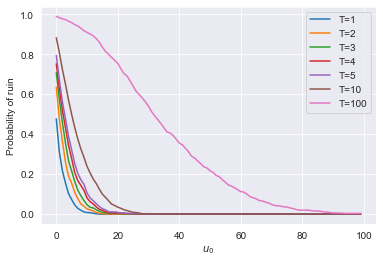

In [52]:
rp.MC_ruin_probability()

In [53]:
rp.PC_simulate(steps=10000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


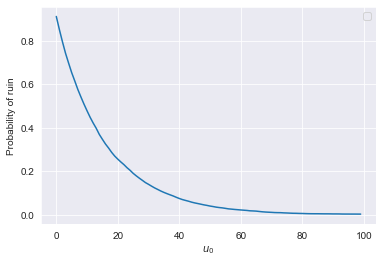

In [54]:
rp.PC_ruin_probability()

In [55]:
rp.Vylder_simulate()

TypeError: '>' not supported between instances of 'str' and 'int'

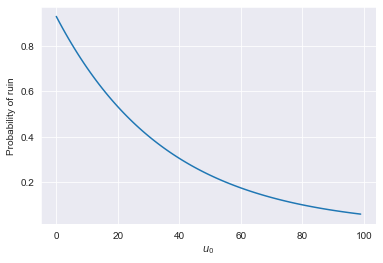

In [33]:
rp.Vylder_ruin_probability()

In [5]:
cp = CompoundPoisson(PoissonProcess(t=0.01, T=10, lbd=10), 10)

TypeError: CompoundPoisson.__init__() missing 1 required positional argument: 'parameters'

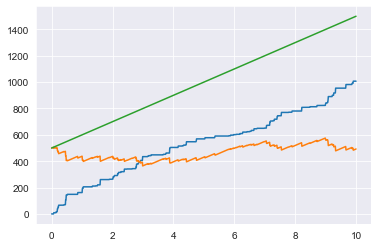

In [4]:
cp.plot()
c = 100
t_vec = np.arange(0, 10.01, step=0.01)
plt.plot(t_vec, 500 + c*t_vec - np.array(cp.trajectory))
plt.plot(t_vec, 500 + c*t_vec)

In [51]:
monte_carlo_steps = 1000
min_vals_vec = np.zeros(monte_carlo_steps)
theta = 0.15
poisson_lambda = 1
expon_lambda = 1
delta_t = 0.01
T = 1000    

In [52]:
for mcs in np.arange(monte_carlo_steps):
    cp = CompoundPoisson(PoissonProcess(t=delta_t, T=T, lbd=poisson_lambda), expon_lambda)
    risk_process_trajectory = (theta + 1)*poisson_lambda/expon_lambda * np.arange(0, T + delta_t, step=delta_t) - cp.trajectory
    min_vals_vec[mcs] = np.min(risk_process_trajectory)

In [53]:
u_max = 40
ruin_probability = np.zeros(u_max + 1)
for u in np.arange(u_max + 1):
    min_vals_u_vec = min_vals_vec + u
    ruin_probability[u] = np.sum(min_vals_u_vec < 0)/monte_carlo_steps
    

Text(0.5, 0, '$u$')

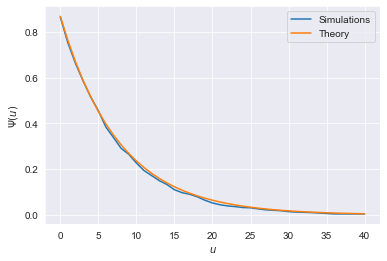

In [54]:
plt.plot(np.arange(u_max + 1), ruin_probability, label="Simulations")
plt.plot(np.arange(u_max + 1), (1/(1+theta))*np.exp((-expon_lambda*theta*np.arange(u_max + 1))/(1+theta)), label="Theory")
plt.legend()
plt.ylabel("$\Psi(u)$")
plt.xlabel("$u$")

In [7]:
cp = CompoundPoisson(PoissonProcess(t=0.01, T=10, lbd=10), "pareto", {"alpha":3, "lmbd":10})

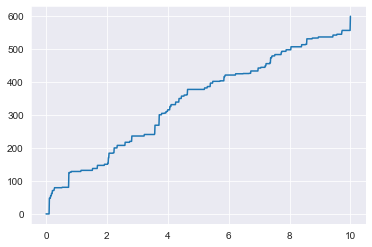

In [8]:
cp.plot()

In [39]:
simulations_num = 1000
delta_t = 0.01
T = 100
poisson_lambda = 3
theta = 0.1
p = theta/(1+theta)
alpha = 3
lmbd_par = 5
expect_val = lmbd_par/(alpha - 1)
min_vals_vec = np.zeros(simulations_num)

for sim in np.arange(simulations_num):
    cp = CompoundPoisson(PoissonProcess(t=delta_t, T=T, lbd=poisson_lambda), "pareto", {"alpha":alpha, "lmbd":lmbd_par})
    risk_process_trajectory = (theta + 1)*expect_val*poisson_lambda*np.arange(0, T + delta_t, step=delta_t) - cp.trajectory
    min_vals_vec[sim] = np.min(risk_process_trajectory)

In [ ]:
LOMAX - distribution in scipy

In [21]:
u_max = 200
ruin_probability = np.zeros(u_max + 1)


for u in np.arange(u_max + 1):
    min_vals_u_vec = min_vals_vec + u
    ruin_probability[(T, u)] = np.sum(min_vals_u_vec < 0)/simulations_num

In [37]:
ruin_probability[(3,)]

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.

In [31]:
min_vals_u_vec[:int(T/delta_t)]

array([-223.72853546, -364.89597154, -301.97351164, -152.81377298,
       -377.08685056, -517.6877932 , -282.22370098, -506.45592998,
       -455.97799059, -372.47806633, -352.45533099, -243.90387106,
       -399.72714158, -313.1744256 , -302.99054028, -241.30275697,
       -336.4631615 , -377.78276693, -331.7667739 , -257.00868535,
       -287.75070791, -221.26022001, -258.43431883, -268.62249139,
       -230.70891453, -242.71048853, -303.31406356, -442.37115445,
       -277.80808198, -346.46913321, -337.40252816, -205.61392043,
       -211.47976914, -360.54037055, -356.61582189, -319.33354682,
       -198.89121182, -193.86040059, -318.01975619, -343.07591665,
       -179.44128479, -349.97620603, -377.96380019, -339.74506323,
       -191.02765345, -375.4498282 , -247.22230437, -267.47873963,
       -280.11857158, -157.46545453, -274.91574048, -273.45606141,
       -287.12248221, -420.45704521, -289.83506192, -290.87283986,
       -155.82675011, -294.8557298 , -185.46675413, -390.76685

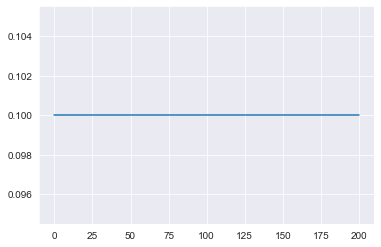

In [29]:
plt.plot(ruin_probability[(1,)])

In [25]:
ruin_probability

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       ...,
       [1. , 1. , 1. , ..., 1. , 1. , 1. ],
       [1. , 1. , 1. , ..., 1. , 1. , 1. ],
       [1. , 1. , 1. , ..., 1. , 1. , 1. ]])

In [ ]:
class PoissonProcess():
    
    def __init__(self, t, T, lbd):
        
        self.t = t
        self.T = T
        self.N = int(T/t)
        self.lbd = lbd
        poisson_rvs = ss.poisson.rvs(lbd*self.t, size=self.N)
        self.increments = poisson_rvs
        self.trajectory = np.concatenate([np.zeros(1), np.cumsum(poisson_rvs)])
        
    def plot(self):
        
        plt.plot(np.arange(0, self.T+self.t, step=self.t), self.trajectory)
        plt.ylabel("$N_t$")
        plt.xlabel("t")
        plt.title(f'Poisson process with $\delta t = {self.t}$, $T = {self.T}$ and $\lambda = {self.lbd}$')
        plt.show()
        
    def EN(self):
        return np.mean(self.trajectory)
    
    def VarN(self):
        return np.var(self.trajectory)
    
    def ENt(self):
        return [np.mean(self.trajectory[:i]) for i in np.arange(1, self.N + 1)]
    
    def VarNt(self):
        return [np.var(self.trajectory[:i]) for i in np.arange(1, self.N + 1)]
    

def generate_pareto(lbd, alpha, num):
    uni_rand = ss.uniform.rvs(size=num)
    return lbd/((1-uni_rand)**(1/alpha)) - lbd
        
class CompoundPoisson():
    
    def __init__(self, poisson_process, distribution, parameters):
        
        self.t = poisson_process.t
        self.T = poisson_process.T
        self.N = poisson_process.N
        self.poisson_trajectory = poisson_process.trajectory
        
        if distribution == "exp":
            self.X = ss.expon.rvs(scale=parameters["lmbd"], size=int(self.poisson_trajectory[-1]))
            self.exp_X = 1/parameters["lmbd"]
        elif distribution == "pareto":
            self.X = ss.lomax.rvs(c=parameters["alpha"], scale=parameters["lmbd"], num=int(self.poisson_trajectory[-1]))
            self.exp_X = parameters["lmbd"]/(parameters["alpha"] - 1)
        elif distribution == "uniform":
            self.X = ss.uniform.rvs(parameters["a"], parameters["b"], size=int(self.poisson_trajectory[-1]))
            self.exp_X = (parameters["a"] + parameters["b"])/2
        elif distribution == "mixed":
            choices = np.random.choice([1, 2], size=int(self.poisson_trajectory[-1]), p=[parameters["p"], 1 - parameters["p"]])
            self.X = np.where(choices == 1, ss.expon.rvs(scale=parameters["lmbd_1"], size=int(self.poisson_trajectory[-1])), ss.expon.rvs(scale=parameters["lmbd_2"], size=int(self.poisson_trajectory[-1])))
            self.exp_X = parameters["p"]/parameters["lmbd_1"] + parameters["p"]/parameters["lmbd_2"]
        
        self.trajectory = [np.sum(self.X[:int(n)]) for n in self.poisson_trajectory]
        self.exp_N = poisson_process.lbd
        
    def plot(self):
        
        plt.plot(np.arange(0, self.T + self.t, step=self.t), self.trajectory)    

#theta = 0.1        
class RuinProcess():
    
    def __init__(self, X_distribution, X_parameters, theta=0.1, poisson_lbd=10, delta_t=0.01, T=10):
        
        self.X_distribution = X_distribution
        self.X_parameters = X_parameters
        
        self.poisson_lbd = poisson_lbd
        self.delta_t = delta_t
        self.T = T
        
        self.theta = theta
        
        
    def simulate(self, u0=0):
        
        compound_poisson = CompoundPoisson(PoissonProcess(self.delta_t, self.T, self.poisson_lbd), self.X_distribution, self.X_parameters)
        
        self.ruin_process_time_series = u0 + (1+ self.theta)*compound_poisson.exp_X*self.poisson_lbd*np.arange(0, self.T + self.delta_t, step=self.delta_t) - compound_poisson.trajectory
     
        
    def MC_simulate(self, steps, T_arr):
        
        self.mcs = steps
                
        for T in T_arr:
            if T > self.T:
                raise ValueError(f'{T} is bigger than {self.T}')
                
        min_vals_vec = np.zeros((len(T_arr), steps))
        
        
        for mcs in np.arange(steps):
            self.simulate(u0=0)
            for i, T in enumerate(T_arr):
                min_vals_vec[(i, mcs)] = np.min(self.ruin_process_time_series[:int(T/self.delta_t)])
                
        self.T_arr = T_arr
        self.min_vals_vec = min_vals_vec
        
     
    def MC_ruin_probability(self, u_vec = np.arange(0, 100), plot=True):
        
        self.ruin_probability_MC = {}
        self.u_vec = u_vec
        
        for i, T in enumerate(self.T_arr):
            self.ruin_probability_MC[T] = np.zeros(len(u_vec))
            for j, u in enumerate(u_vec):
                min_vals_u_vec = self.min_vals_vec[i] + u
                self.ruin_probability_MC[T][j] = np.sum(min_vals_u_vec < 0)/self.mcs
        
        if plot:  
            for T in self.T_arr:      
                plt.plot(u_vec, self.ruin_probability_MC[T], label=f'T={T}')
            plt.legend()
            plt.xlabel("$u_0$")
            plt.ylabel("Probability of ruin")
                      
    def PC_simulate(self, steps):
        
        self.PC_steps = steps
        
        N_vec = np.zeros(steps)
        
        for step in np.arange(steps):
            num_of_aggregate_losses = ss.geom.rvs(p=(self.theta/(1+self.theta))) - 1
            
            if self.X_distribution == "pareto":
                N_vec[step] = np.sum(ss.lomax.rvs(scale=self.X_parameters["lmbd"], c=self.X_parameters["alpha"]-1, num=int(num_of_aggregate_losses)))
            
            elif self.X_distribution == "exp":
                N_vec[step] = np.sum(ss.expon.rvs(scale=self.X_parameters["lmbd"], size=int(num_of_aggregate_losses)))
                
            elif self.X_distribution == "uniform":
                N_vec[step] = np.sum(ss.triang.rvs(self.X_parameters["a"], loc=0, scale=self.X_parameters["b"], size=int(num_of_aggregate_losses)))
                
            elif self.X_distribution == "mixed":
                old_p = self.X_parameters["p"]
                lmbd_1 = self.X_parameters["lmbd_1"]
                lmbd_2 = self.X_parameters["lmbd_2"]
                
                new_p = (old_p*lmbd_2)/(old_p*lmbd_2 + (1-old_p)*lmbd_1)
                
                choices = np.random.choice([1, 2], size=int(num_of_aggregate_losses), p=[new_p, 1 - new_p])
                N_vec[step] = np.sum(np.where(choices == 1, ss.expon.rvs(scale=lmbd_1, size=int(num_of_aggregate_losses)), ss.expon.rvs(scale=lmbd_2, size=int(num_of_aggregate_losses))))
                
        
        self.N_vec = N_vec
        
    def PC_ruin_probability(self, u_vec = np.arange(0, 100), plot=True):
        
        self.ruin_probability_PC = np.zeros(len(u_vec))
        self.u_vec = u_vec
        
        for j, u in enumerate(u_vec):
            self.ruin_probability_PC[j] = np.sum(self.N_vec > u)/self.PC_steps
        
           
        plt.plot(u_vec, self.ruin_probability_PC)
        plt.legend()
        plt.xlabel("$u_0$")
        plt.ylabel("Probability of ruin")
        
        
    def Vylder_simulate(self):
        
        if self.X_distribution == "exp":
            p1 = ss.expon.moment(1, scale=self.X_parameters["lmbd"])
            p2 = ss.expon.moment(2, scale=self.X_parameters["lmbd"])
            p3 = ss.expon.moment(3, scale=self.X_parameters["lmbd"])
            
        elif self.X_distribution == "uniform":
            p1 = ss.uniform.moment(1, loc=self.X_parameters["a"], scale=self.X_parameters["b"])
            p2 = ss.uniform.moment(2, loc=self.X_parameters["a"], scale=self.X_parameters["b"])
            p3 = ss.uniform.moment(3, loc=self.X_parameters["a"], scale=self.X_parameters["b"]) 
            
        elif self.X_distribution == "mixed":
            p1 = self.X_parameters["p"]*ss.expon.moment(1, scale="lmbd_1") + (1-self.X_parameters["p"])*ss.expon.moment(1, scale="lmbd_2")
            p2 = self.X_parameters["p"]*ss.expon.moment(2, scale="lmbd_1") + (1-self.X_parameters["p"])*ss.expon.moment(2, scale="lmbd_2")
            p3 = self.X_parameters["p"]*ss.expon.moment(3, scale="lmbd_1") + (1-self.X_parameters["p"])*ss.expon.moment(3, scale="lmbd_2")
            
            #p1 = self.X_parameters["p"]*self.X_parameters["lmbd_1"] + (1-self.X_parameters["p"])/self.X_parameters["lmbd_2"]
            #p2 = 2*self.X_parameters["p"]/self.X_parameters["lmbd_1"]**2 + 2*(1-self.X_parameters["p"])/self.X_parameters["lmbd_2"]**2
            #p3 = 6*self.X_parameters["p"]/self.X_parameters["lmbd_1"]**3 + 6*(1-self.X_parameters["p"])/self.X_parameters["lmbd_2"]**3
        
        elif self.X_distribution == "pareto":
            p1 = ss.lomax.moment(1, scale=self.X_parameters["lmbd"], c=self.X_parameters["alpha"]-1)
            p2 = ss.lomax.moment(1, scale=self.X_parameters["lmbd"], c=self.X_parameters["alpha"]-1)
            p3 = ss.lomax.moment(1, scale=self.X_parameters["lmbd"], c=self.X_parameters["alpha"]-1)
            
            
        self.lmbd_de_Vylder = 3*p2/p3
        self.theta_de_Vylder = ((2*p1*p3)/(3*p2**2))*self.theta
        
    def Vylder_ruin_probability(self, u_vec = np.arange(0, 100), plot=True):
        
        self.ruin_probability_V = (1/(1+self.theta_de_Vylder))*np.exp(-(self.lmbd_de_Vylder*self.theta_de_Vylder*u_vec)/(1 + self.theta_de_Vylder))
        
        plt.plot(u_vec, self.ruin_probability_V)
        plt.xlabel("$u_0$")
        plt.ylabel("Probability of ruin")
        
    
    
def MC_simulate(steps, T_arr):
    pass
        


            
        
        
              
    